In [2]:
#increase the display size to 95% of window width
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
display(HTML("<style>.output_result { max-width:95% !important; }</style>"))

In [3]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.axisartist
import scipy as sp
import glob
import gc

from matplotlib.ticker import FormatStrFormatter
from shutil import copyfile
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

from functions.mandyocIO import read_datasets, _extract_interface

%matplotlib inline
path = os.getcwd().split('/')

machine_path = '/' + path[1] + '/' + path[2]

In [162]:
#reading dataset information
dataset = [
            'temperature',
            ]# Read data and convert them to xarray.Dataset

#Group 1 CLS - NoHprodAst
# scenario = '/Doutorado/cenarios/mandyoc/stable/NoHprodAst/stable_PT0_rheol19_1Gyr_400ppe_10x10_c_1250_C1' # ok
# scenario = '/Doutorado/cenarios/mandyoc/stable/NoHprodAst/stable_PT100_rheol19_c1250_C1' #
scenario = '/Doutorado/cenarios/mandyoc/stable/NoHprodAst/stable_PT200_rheol19_c1250_C1' #

#Group 2 CPE - HprodAst
#lit80km
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1_HprodAst' #
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT280_rheol19_c1250_C1_HprodAst' #
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT290_rheol19_c1250_C1_HprodAst' #
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT350_rheol19_c1250_C1_HprodAst' #
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT400_rheol19_c1250_C1_HprodAst' #

#lit150km
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT200_rheol19_c1250_C1_HprodAst_Hlit150km/'
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT290_rheol19_c1250_C1_HprodAst_Hlit150km/'
# scenario = '/Doutorado/cenarios/mandyoc/stable/lit150km/stable_DT350_rheol19_c1250_C1_HprodAst_Hlit150km/'

# scenario = '/Doutorado/cenarios/mandyoc/stable/lit80km/stable_PT200_rheol19_c1250_C1'
model_path = machine_path + scenario
dataset = read_datasets(model_path, dataset)

Nx = int(dataset.nx)
Nz = int(dataset.nz)
Lx = float(dataset.lx)
Lz = float(dataset.lz)

z = np.linspace(Lz/1000.0, 0, Nz)
Z = np.linspace(Lz/1000.0, 0, 8001) #zi

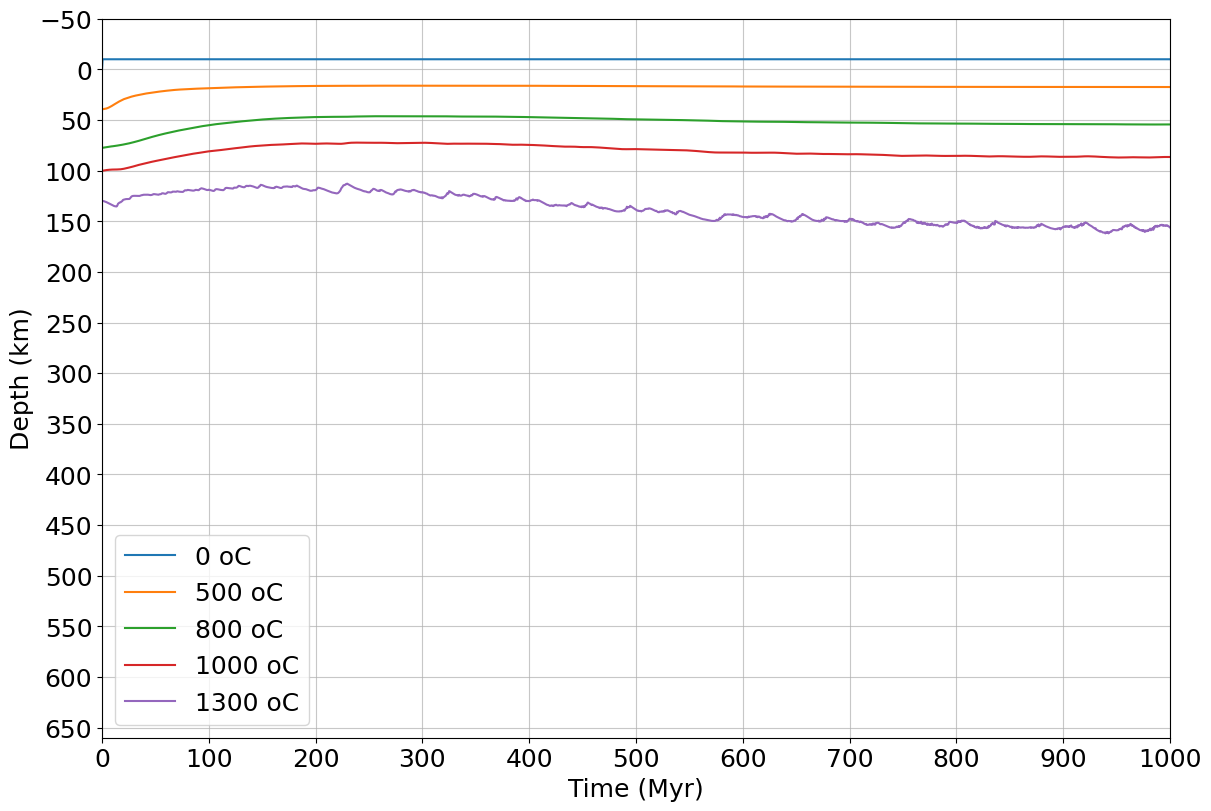

In [163]:
t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

start = int(t0)
end = int(dataset.time.size - 1)
step = 2#5

# start = 0
# end = 10
# step = 1

isotherms_list = [0, 500, 800, 1000, 1300, 1400, 1500, 1600, 1700]
# isotherms_list = [800, 1300]
isotherms_evolution = []

for i in range(start, end+step, step):
    
    per = np.round(100*(i+1-start)/(end-start), 2)
    text = f"Time: {np.round(float(dataset.time[i]), 2)} Myr; Step: {int(dataset.step[i])}/{int(dataset.step.max())}, ({per:.2f}%)."
    print(text, end='\r')
    
    #extracting isotherms interfaces
    for isotherm_item in isotherms_list:
        isotherm_interface = _extract_interface(z, Z, Nx, dataset.temperature[i].T, isotherm_item)
        mean_depth = round(np.mean(isotherm_interface), 2)
        isotherms_evolution.append(mean_depth)
        
        
isotherms_evolution = np.asarray(isotherms_evolution)
nrows = len(range(start, end+1, step))
isotherms_evolution = isotherms_evolution.reshape(nrows, len(isotherms_list)).T

data_vars = {}
for isotherm_item, isotherm_evolution in zip(isotherms_list, isotherms_evolution):
    data_vars[f"isot{isotherm_item}"] = isotherm_evolution
    
coords = {'time': dataset.time[start:end:step]}

isot_dataset = xr.Dataset(data_vars = data_vars,
                               coords = {'time': dataset.time[start:end+step:step]},
                               attrs=dict(description='Isotherms evolution', units='degC')
                              )
isot_dataset.to_netcdf(f"{model_path}/{filename}")

################################################################################################################
plot_evolution = True
if(plot_evolution==True):
    #Plot isotherms mean depth evolution
    isotherms_plots = [0, 500, 800, 1000, 1300]
    label_fsize = 18
    plt.rc('xtick', labelsize=label_fsize)
    plt.rc('ytick', labelsize=label_fsize)

    fig, ax = plt.subplots(1, 1, figsize=(12,8), sharex=True, sharey=True, constrained_layout=True)
    h_air = 40.
    for plot in isotherms_plots:
        ax.plot(isot_dataset.time, isot_dataset[f'isot{plot}'] - h_air, label=f'{plot} oC')

    #set plot details
    ax.set_xlim([0,500])
    ax.set_xticks(np.linspace(0,1000,11))
    ax.set_yticks(np.linspace(-50,650,15))
    ax.set_ylim([660, -50])
    ax.grid(':k', alpha=0.7)
    ax.set_xlabel('Time (Myr)', fontsize=label_fsize)
    ax.set_ylabel('Depth (km)', fontsize=label_fsize)
    ax.legend(loc='best', fontsize=18)

    figname = f"{scenario.split('/')[-1]}_isotherms_evolution"
    fig.savefig(f"out/plots/{figname}.pdf", dpi=400)
    fig.savefig(f"out/plots/{figname}.png", dpi=400)

    # #This will save inside the experiment directory
    fig.savefig(f"{model_path}/{figname}.pdf", dpi=400)
    fig.savefig(f"{model_path}/{figname}.png", dpi=400)

In [153]:
isot_dataset

<xarray.Dataset>
Dimensions:   (isot0: 401, isot500: 401, isot800: 401, isot1000: 401,
               isot1300: 401, isot1400: 401, isot1500: 401, isot1600: 401,
               isot1700: 401, time: 401)
Coordinates:
  * isot0     (isot0) float64 39.99 29.93 29.93 29.93 ... 29.93 29.93 29.93
  * isot500   (isot500) float64 79.45 78.93 78.23 77.0 ... 55.72 55.72 55.73
  * isot800   (isot800) float64 117.3 117.0 116.5 116.1 ... 85.48 85.5 85.53
  * isot1000  (isot1000) float64 140.0 139.7 139.2 138.9 ... 112.4 112.4 112.4
  * isot1300  (isot1300) float64 170.0 170.3 171.3 172.7 ... 161.4 162.2 163.4
  * isot1400  (isot1400) float64 180.0 182.0 184.8 187.3 ... 289.2 287.8 280.3
  * isot1500  (isot1500) float64 190.1 201.5 208.1 213.3 ... 514.5 518.0 521.1
  * isot1600  (isot1600) float64 435.5 434.3 433.1 431.9 ... 665.4 664.6 663.9
  * isot1700  (isot1700) float64 698.4 698.2 698.1 698.0 ... 699.8 699.8 699.8
  * time      (time) float64 0.0 2.5 5.0 7.5 10.0 ... 992.5 995.0 997.5 1e+03
Data variables:
    *empty*
Attributes:
    description:  Isotherms evolution
    units:        degC

In [168]:
t0 = dataset.time[0]
t1 = dataset.time[1]
dt = int(t1 - t0)

start = int(t0)
end = int(dataset.time.size - 1)
step = 2#5

# start = 0
# end = 10
# step = 1

isotherms_list = [0, 500, 800, 1000, 1300, 1400, 1500, 1600, 1700]
# isotherms_list = [800, 1300]

import pymp

size = end+step-start//step* len(isotherms_list)
isotherms_evolution = pymp.shared.array(size, dtype='float64')


with pymp.Parallel() as p:
    for i in p.range(start, end+step, step):
        
        per = np.round(100*(i+1-start)/(end-start), 2)
        text = f"Time: {np.round(float(dataset.time[i]), 2)} Myr; Step: {int(dataset.step[i])}/{int(dataset.step.max())}, ({per:.2f}%)."
#         print(text, end='\r')
        j = 0
        #extracting isotherms interfaces
        for isotherm_item in isotherms_list:
            isotherm_interface = _extract_interface(z, Z, Nx, dataset.temperature[i].T, isotherm_item)
            mean_depth = round(np.mean(isotherm_interface), 2)
            isotherms_evolution[i+j] = mean_depth
            j += 1
            
isotherms_evolution = np.asarray(isotherms_evolution)
nrows = len(range(start, end+1, step))
isotherms_evolution = isotherms_evolution.reshape(nrows, len(isotherms_list)).T

data_vars = {}
for isotherm_item, isotherm_evolution in zip(isotherms_list, isotherms_evolution):
    data_vars[f"isot{isotherm_item}"] = isotherm_evolution
    
coords = {'time': dataset.time[start:end:step]}

isot_dataset = xr.Dataset(data_vars = data_vars,
                               coords = {'time': dataset.time[start:end+step:step]},
                               attrs=dict(description='Isotherms evolution', units='degC')
                              )
# isot_dataset.to_netcdf(f"{model_path}/{filename}")

An exception occured in thread 11: (<class 'IndexError'>, index 4002 is out of bounds for axis 0 with size 4002).


IndexError: index 4002 is out of bounds for axis 0 with size 4002

In [ ]:
dataset

In [33]:
coords = {'time':times}
dims = ('time')
isotherm_dataset = xr.Dataset(data_vars=dict(isotherms_evolution_aux),
                              attrs=dict(description='Isotherms mean depth',
                                           units='degC'))

ValueError: dictionary update sequence element #0 has length 11; 2 is required